# Load Import Libraries

In [1]:
import numpy as np
import math
import obspy
from seispy.decon import RFTrace
import seispy
import scipy
import scipy.io as sio
import scipy.io as spio
import scipy.io
from scipy.io import savemat
from scipy.io import loadmat
from matplotlib import pyplot as plt
from future.utils import native_str
import os
from obspy.core import UTCDateTime
import sys
from scipy import interpolate
from scipy.interpolate import interp1d
from os.path import dirname, join as pjoin
from scipy import signal
from obspy import read
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
import pandas as pd

# Set All Parameters
# Code, Function[dseis] = decon(fseis,source,water_level)
# RF function

In [2]:
def reciever_function(trace,source,water_level=0.01,tshift=10):
    '''
    To have the Reciever_function(trace,source,water_level=1000,tshift=10), input the stream in (E,N,Z) directions 
    and rotate them in (R-T-Z)component, For the rotation process, we need to be careful to separate specific 
    parts of the traces to make sure that we have first "P" arrivals.
    Source and trace are single traces, and then we need to produce a single deconvolved trace. 
    By each corresponding Source and apply ifft,(the value of water_level(damping factor) and t-shift have been
    recommended).The results help to make Reciever_function for the station.
    '''
    slength = (trace.data).shape[0]
    source_matrix = np.matrix(source)
    nsrc = source_matrix.shape[0]
    trace_matrix = np.matrix(trace)
    ntr = trace_matrix.shape[0]
    n2=2**(math.ceil(math.log(slength)/math.log(2)))
    omega = np.arange(0,n2/2)*2*(math.pi)/(n2*delta)
    wtshift = -(1j)*omega*tshift
    traceft = np.fft.fft([st_rot.traces[1].data],n2,axis=1)
    sourceft = np.fft.fft([st_rot.traces[2].data],n2,axis=1)
    traceft = traceft[:,0:int(n2/2)]
    sourceft = sourceft[:,0:int(n2/2)]
    traceft_real = (traceft.real)[0]
    sourceft_real = (sourceft.real)[0]
    dseisft = np.multiply(traceft,np.conjugate(sourceft))/(np.multiply(sourceft,np.conjugate(sourceft))+water_level)
    dseisft_real = (dseisft.real)[0]
    zeros_wtshift = np.zeros_like(wtshift)
    dseisft=np.multiply(dseisft,(np.ones((1,1))*np.exp(zeros_wtshift)))
    dseisfttrans = np.array(np.transpose(dseisft))
    dseisftfinal =np.concatenate([dseisfttrans,np.fliplr(np.conjugate(dseisfttrans[1:int(n2/2)]))])
    rf = np.fft.irfft(dseisftfinal,n2,0)
    rf = (rf[0:slength])
    return(rf,omega,wtshift,dseisft_real) 

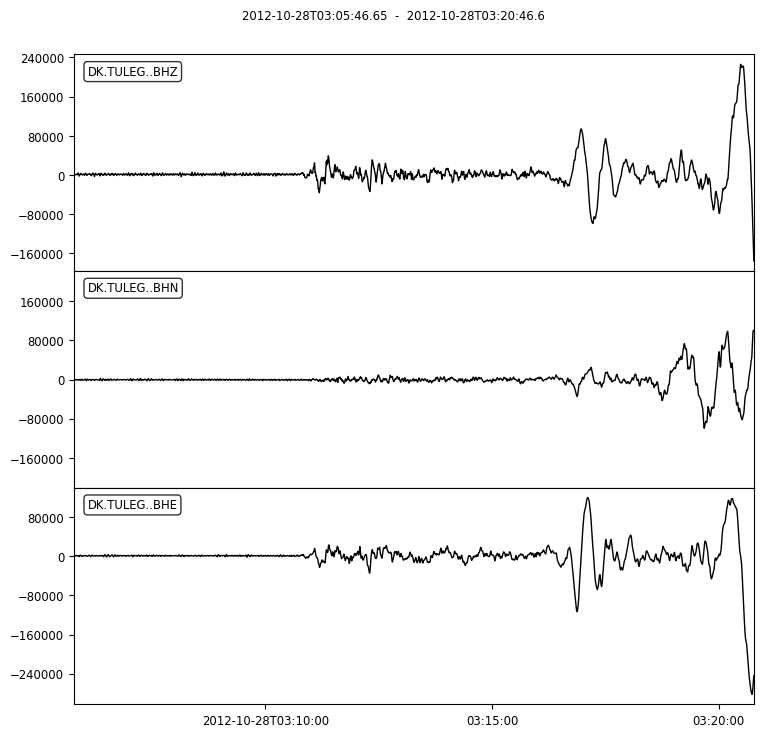

1 arrivals
	P phase arrival at 398.861 seconds


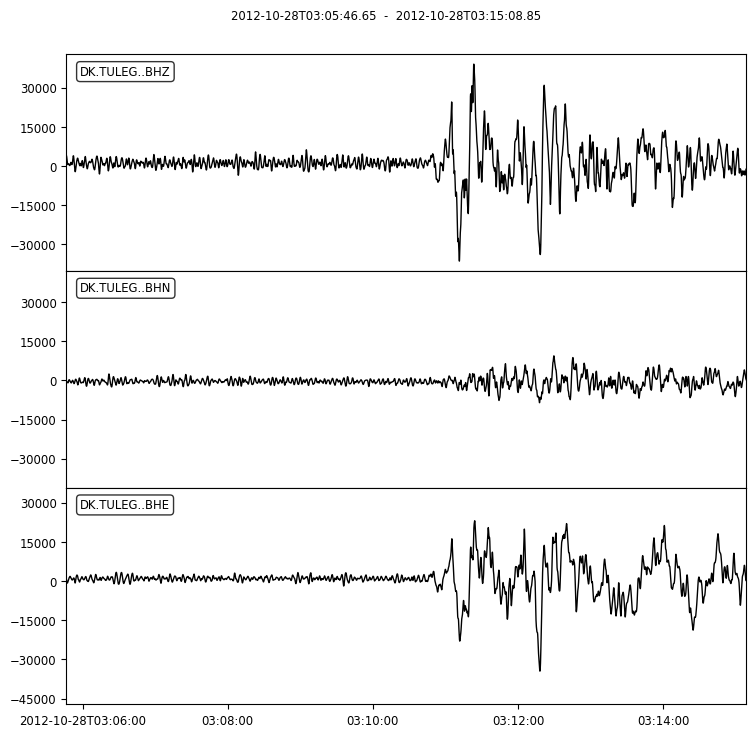

In [13]:
st = obspy.read('/home/zahra/reciever function/test3/DK.TULEG..BH*_2012-10-28T03_05_46.637_2012-10-28T03_20_46.637.sac')
tr = st[0].stats
st.plot()
print(tr)
arrivals = model.get_travel_times(source_depth_in_km=7.04,distance_in_degree=33.38,phase_list=["P"])
print(arrivals)
dt = UTCDateTime("2012-10-28T03:05:10")
st.trim(starttime =dt, endtime=dt+200+398.861)

st.plot()
st.plot(outfile='ThreeComponentAfterTrimBeforeRotateMag7.8Dis:33.png')
tr1 = st[0].stats
print(tr1)

delta =0.05
water_level=0.01

tr2 = st[0]

da = seispy.distaz(st[0].stats.sac.stla, st[0].stats.sac.stlo,st[0].stats.sac.evla, st[0].stats.sac.evlo)
dis = da.delta
bazi = da.baz
ev_dep = st[0].stats.sac.evdp
print('Distance = %5.2f˚' %dis)
print('back_azimuth = %5.2f˚' %bazi)
st_rot = st.copy().rotate("NE->RT", back_azimuth=bazi)

trace =  st_rot.traces[1]
source = st_rot.traces[0]

rf,omega,wtshift,dseisft_real=reciever_function(trace,source,water_level)

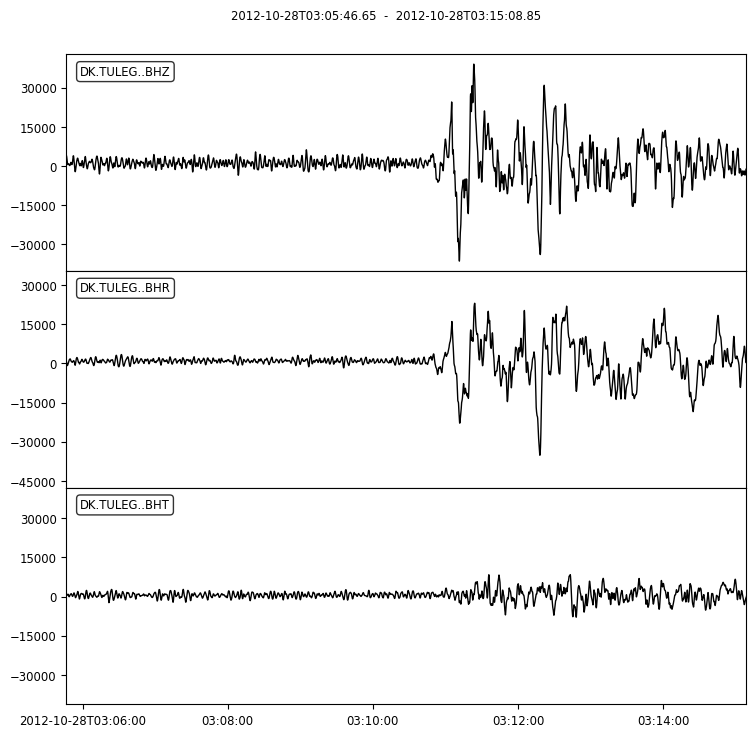

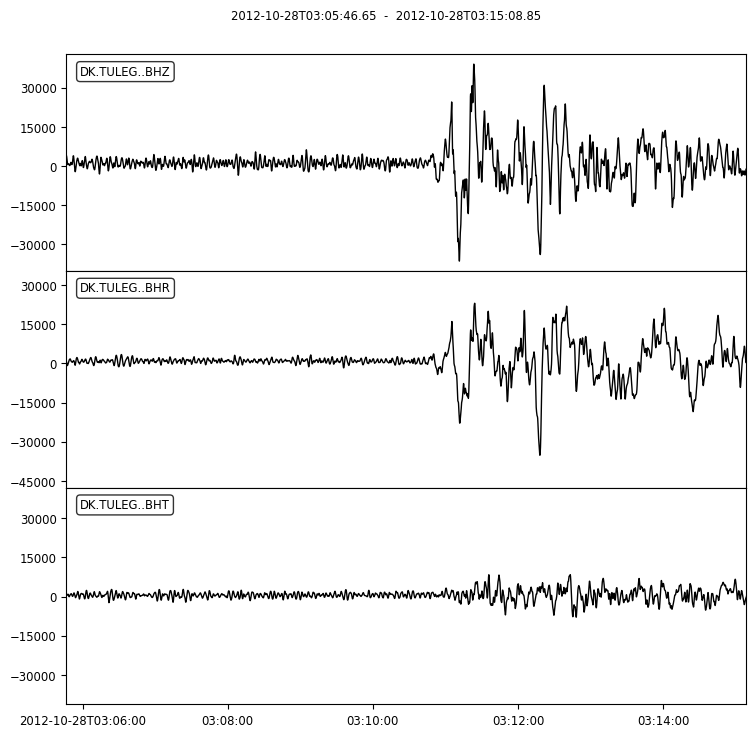

In [12]:
st_rot.plot()